In [9]:
import re
import community
import networkx as nx
import pandas as pd
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import xlrd

from igraph import * 

In [10]:
# 先读xlsx文件，并转成dataframe

df = pd.read_excel('./BiliBiliComments.xlsx')
df['content'] = df['content'].astype(str)


In [11]:
df

,Unnamed: 0,root,uid,uname,usex,ulevel,rpid,like,time,content
0,0,0,3907,奔跑呀,保密,6,4720941640,4550,2021-06-13 17:36:28,全靠自来水给你们流量，那给你们的宣传经费都弄哪了？都花在制作上了啊，哦，那没事了。
1,1,4720941640,29041209,朝朝暮暮长,女,5,4722257822,220,2021-06-13 21:17:50,大概是保密局宣传的吧[doge]
2,2,4720941640,11969756,Tiger123456,保密,6,4722793998,16,2021-06-13 22:42:34,回复 @朝朝暮暮长 :卧槽，你要笑死我[笑哭]
3,3,4720941640,392092219,花四怂不怂,保密,5,4726184812,2,2021-06-14 14:15:42,回复 @朝朝暮暮长 :宣发不给力啊[嗑瓜子]
4,4,4720941640,237243184,追星星的鱼yu,女,5,4728204580,75,2021-06-14 20:17:02,老艺术家是白嫖的，青年演员是兼职的，连热度都是观众贡献的（不愧是我河能省）[doge]
...,...,...,...,...,...,...,...,...,...,...
52275,126,4713408025,1152150487,河南春晚官方,保密,6,4713428860,0,2021-06-12 12:19:41,时刻准备着[粽子][粽子]
52276,127,0,51045380,今天一定不修仙,保密,5,4713407767,0,2021-06-12 12:16:23,粽子哥哥大可爱了[粽子]
52277,128,0,67363233,MekkyZY,女,6,4713407693,0,2021-06-12 12:16:21,期待期待！
52278,129,0,39756445,幽古剑,女,5,4713407130,0,2021-06-12 12:16:02,可爱！！！


In [12]:
print(df.loc[20617])

Unnamed: 0                    126
root                   4716528320
uid                     160964611
uname                       小娄沒吃飽
usex                            男
ulevel                          5
rpid                   4716651105
like                            7
time          2021-06-12 22:35:22
content                 [热词系列_吹爆]
Name: 20617, dtype: object


In [13]:
# ！！！检查缺失值
df=df.dropna()

# 52280-》52171 果然有缺失值
# 但是这时候索引没改变，需要更新索引
df = df.reset_index(drop=True)
df

,Unnamed: 0,root,uid,uname,usex,ulevel,rpid,like,time,content
0,0,0,3907,奔跑呀,保密,6,4720941640,4550,2021-06-13 17:36:28,全靠自来水给你们流量，那给你们的宣传经费都弄哪了？都花在制作上了啊，哦，那没事了。
1,1,4720941640,29041209,朝朝暮暮长,女,5,4722257822,220,2021-06-13 21:17:50,大概是保密局宣传的吧[doge]
2,2,4720941640,11969756,Tiger123456,保密,6,4722793998,16,2021-06-13 22:42:34,回复 @朝朝暮暮长 :卧槽，你要笑死我[笑哭]
3,3,4720941640,392092219,花四怂不怂,保密,5,4726184812,2,2021-06-14 14:15:42,回复 @朝朝暮暮长 :宣发不给力啊[嗑瓜子]
4,4,4720941640,237243184,追星星的鱼yu,女,5,4728204580,75,2021-06-14 20:17:02,老艺术家是白嫖的，青年演员是兼职的，连热度都是观众贡献的（不愧是我河能省）[doge]
...,...,...,...,...,...,...,...,...,...,...
52166,126,4713408025,1152150487,河南春晚官方,保密,6,4713428860,0,2021-06-12 12:19:41,时刻准备着[粽子][粽子]
52167,127,0,51045380,今天一定不修仙,保密,5,4713407767,0,2021-06-12 12:16:23,粽子哥哥大可爱了[粽子]
52168,128,0,67363233,MekkyZY,女,6,4713407693,0,2021-06-12 12:16:21,期待期待！
52169,129,0,39756445,幽古剑,女,5,4713407130,0,2021-06-12 12:16:02,可爱！！！


In [14]:
# 先提取用户信息表和评论信息表
dfusers = df[['uid','uname','usex','ulevel']].drop_duplicates()
dfusers
# print(len(dfusers['uname'].unique()))
# 姓名不是唯一值

,uid,uname,usex,ulevel
0,3907,奔跑呀,保密,6
1,29041209,朝朝暮暮长,女,5
2,11969756,Tiger123456,保密,6
3,392092219,花四怂不怂,保密,5
4,237243184,追星星的鱼yu,女,5
...,...,...,...,...
52164,373045636,Soul七磅,保密,5
52165,23895116,扶不起来的春仔,保密,6
52167,51045380,今天一定不修仙,保密,5
52169,39756445,幽古剑,女,5


In [15]:
dfusers2 = dfusers.drop_duplicates(subset=['uname'],keep='first') #保留重复数据的第一个
dfusers2.info()
# 35244-》35052 果然有重复值


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35052 entries, 0 to 52170
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uid     35052 non-null  int64 
 1   uname   35052 non-null  object
 2   usex    35052 non-null  object
 3   ulevel  35052 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [16]:
# 再提取评论表contents，包含属性：评论rpid+评论内容
dfcontents = df[['rpid', 'content','like']]
dfcontents


,rpid,content,like
0,4720941640,全靠自来水给你们流量，那给你们的宣传经费都弄哪了？都花在制作上了啊，哦，那没事了。,4550
1,4722257822,大概是保密局宣传的吧[doge],220
2,4722793998,回复 @朝朝暮暮长 :卧槽，你要笑死我[笑哭],16
3,4726184812,回复 @朝朝暮暮长 :宣发不给力啊[嗑瓜子],2
4,4728204580,老艺术家是白嫖的，青年演员是兼职的，连热度都是观众贡献的（不愧是我河能省）[doge],75
...,...,...,...
52166,4713428860,时刻准备着[粽子][粽子],0
52167,4713407767,粽子哥哥大可爱了[粽子],0
52168,4713407693,期待期待！,0
52169,4713407130,可爱！！！,0


In [28]:
# 提取用户-评论表users,使用groupby函数,将不同评论合并成列表

dfuc = df.groupby(df['uid']).rpid.apply(list).to_frame().reset_index()
print(dfuc)

# ！！！！！这里可以进一步统计出每个人评论了多少次？计算list长度即可
# ！！！！！

                    uid            rpid
0                  3907    [4720941640]
1                 11491    [4727812048]
2                 13597    [4719837648]
3                 14751    [4873502824]
4                 15056    [4723129308]
...                 ...             ...
35225        2142354565    [4751495458]
35226        2143983167    [4766342577]
35227        2146916531    [4761306302]
35228        2146973404    [4734773158]
35229  3493080808294960  [139454446944]

[35230 rows x 2 columns]


In [18]:
dfuc.to_csv('dfuc.csv',index = False)

IndexError: list index out of range

In [20]:
dfuc['rpid'] = dfuc['rpid'].astype(str)
dfuc.head()

,uid,rpid
0,3907,[4720941640]
1,11491,[4727812048]
2,13597,[4719837648]
3,14751,[4873502824]
4,15056,[4723129308]


In [26]:
my_index = dfuc.rpid.str.len().sort_values().index
dfuc.reindex(my_index)
#dfuc.head()

,uid,rpid
0,3907,[4720941640]
21937,325390776,[4723817593]
21936,325387628,[4717054304]
21935,325381826,[4721587688]
21934,325376878,[4720061280]
...,...,...
30524,489381964,"[4751358394, 4733639309, 4734089910, 473397223..."
31778,518427559,"[4726155605, 4726188800, 4726184455, 472620178..."
31938,522656020,"[4719184579, 4719171512, 4719142091, 474584730..."
25728,393367659,"[4718542115, 4718706385, 4718775683, 471878131..."


In [24]:
# 构造互动关系表edgelist，包含属性：两个用户节点uid


# 先设置一个空表来保存edgelist
edgelist = pd.DataFrame()
# 这个空表用来存储孤立节点
lonelynode = pd.DataFrame()

def is_mention(text):
    if "回复 @" in text:
        return True

def getuid(text):
    # 设置正则规则
    rule = r'@(.*?) :'
    # 根据规则截取特定子字符串
    getnamelist = re.findall(rule, text) # findall函数输出list格式
    getname = ''.join(getnamelist) # 将list转成str模式，方便下一步使用loc条件判断做匹配
    # getuidname = dfusers2.loc[dfusers2['uname']==getname,'uname'].item()
    if getname in dfusers2['uname'].values: # 说明是改名了
        getuidname = dfusers2.loc[dfusers2['uname']==getname,'uname'].item()
    else:
        getuidname = "你为什么要改名阿啊阿啊阿啊阿啊阿啊阿啊"
    # print(getname,getuid)
    return getuidname


# 循环df中所有记录
for i in range(0, len(df)):
    if df.iloc[i]['root'] in list(df['rpid']):
        if is_mention(df.iloc[i]['content']):# 这里需要写一个判断是否存在@的函数
            temp_target = getuid(df.iloc[i]['content'])
            # print(temp_target)
            edgelist = edgelist.append(pd.DataFrame({'source':[df.iloc[i]['uname']], 
                                                     'target':[temp_target]}), ignore_index=True)
        else: # 之前的报错……是由于未清洗数据……有重复值……
            # type([df.loc[df.iloc[i]['root']==df['rpid'],'uname']])
            # print([df.loc[df['rpid']==df.iloc[i]['root'],'uname']])       data[data['a'].isin([1])]
            edgelist = edgelist.append(pd.DataFrame({'source':[df.iloc[i]['uname']], 
                                                     'target':[df.loc[df['rpid']==df.iloc[i]['root'],'uname'].item()]}), ignore_index=True)
    else:
        # print("根节点") # 到时候单独列孤立节点
        pass
        
        
# 然后写一个判断是否还剩下孤立节点的函数，找出孤立节点
# 要不要把自己评论自己的edgelist记录删掉？
# 应该先删除自己评论自己的记录，再找出剩下孤立节点（因为有可能一个人只有自己评论自己，产生了关系数据，但实际上他是孤立的）
for i in range(0,len(edgelist)):
    if edgelist.iloc[i]['source'] == edgelist.iloc[i]['target']:
        edgelist2 = edgelist.drop(df.index[i])  # 删除首尾节点都是自己的   
        
# 把两列数据全部合并起来（取唯一值），在原来的dfusers表中找剩下的 
haveedgelist1 = edgelist2['source'].tolist()
haveedgelist2 = edgelist2['target'].tolist() 
haveedgelist = haveedgelist1+haveedgelist2
haveedgelist = list(set(haveedgelist))
# 找剩下的节点
for i in range(0, len(dfusers2)):
    if dfusers2.iloc[i]['uname'] not in haveedgelist:
        lonelynode = lonelynode.append(pd.DataFrame({'source':[dfusers2.iloc[i]['uname']], 'target':[None]}), ignore_index=True)

        

# writer = pd.ExcelWriter('edgelist.xlsx')
# edgelist.to_excel(writer)       


/var/folders/ll/xx5jng3s4fs5dqmstx6z2_hw0000gn/T/ipykernel_2978/3741641710.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  edgelist = edgelist.append(pd.DataFrame({'source':[df.iloc[i]['uname']],
/var/folders/ll/xx5jng3s4fs5dqmstx6z2_hw0000gn/T/ipykernel_2978/3741641710.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  edgelist = edgelist.append(pd.DataFrame({'source':[df.iloc[i]['uname']],
/var/folders/ll/xx5jng3s4fs5dqmstx6z2_hw0000gn/T/ipykernel_2978/3741641710.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lonelynode = lonelynode.append(pd.DataFrame({'source':[dfusers2.iloc[i]['uname']], 'target':[None]}), ignore_index=True)


In [25]:
edgelist2 # edglist2是删除了自己评论自己的关系后的表
print(len(edgelist2))
edgelist2['target'].value_counts()


20582


你为什么要改名阿啊阿啊阿啊阿啊阿啊阿啊    2719
河南共青团                   451
河南春晚官方                  390
清枫浦上灬                   368
狼行者阿诗铃                  223
                       ... 
糯米纸鸭                      1
SnoopyYa                  1
所罗斯特                      1
小楼深巷里                     1
扶不起来的春仔                   1
Name: target, Length: 3687, dtype: int64

In [26]:
# 要不要把这些改名的提取出来，自己去判断一下？？？
changename = pd.DataFrame()
changename = edgelist2.loc[(edgelist2['target']=="你为什么要改名阿啊阿啊阿啊阿啊阿啊阿啊")]
# changename
changename.to_excel('changename.xlsx',index = False) # 把这些改名的保存起来

In [49]:
# 算了，还是直接删掉吧
edgelist3 = edgelist2.drop(edgelist2[(edgelist2['target'] == "你为什么要改名阿啊阿啊阿啊阿啊阿啊阿啊")].index)
edgelist3 = edgelist3.reset_index(drop=True)
edgelist3.info() # edgelist3是删除了那些改名了，不知道如何判断关系的表

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17863 entries, 0 to 17862
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  17863 non-null  object
 1   target  17863 non-null  object
dtypes: object(2)
memory usage: 279.2+ KB


In [50]:
edgelist3

,source,target
0,朝朝暮暮长,奔跑呀
1,Tiger123456,朝朝暮暮长
2,花四怂不怂,朝朝暮暮长
3,追星星的鱼yu,奔跑呀
4,姝诺,奔跑呀
...,...,...
17858,一只萧洋,HY喜洋洋
17859,太空旅客斯维坦,云染开月色
17860,河南春晚官方,__天空之城
17861,阿皮休,兔兔兔兔1949


In [29]:
# 还是得做有向图

In [30]:


# a评论了b，b又评论了a，但实际上，这是同一个关系，取一个就好
# 先让两列元素互换，然后合并，再删去重复值，就可以实现上述目标
# edgelist3[['source', 'target']] = edgelist3[['target', 'source']]

# 交换了两列，但不是元素，所以还需要更改列名
# cols = list(edgelist3)
# cols.insert(0,cols.pop(cols.index('target')))
# edgelist4 = edgelist3.loc[:,cols]
# # 更改两个列名
# edgelist4.columns = ['source','target']

# # edgelist4 

# # 合并edgelist3和edgelist4，再删除重复值
# edgelist5 = edgelist3.append(edgelist4).drop_duplicates()
# edgelist5

In [51]:
edgelist3.to_csv('edgelist.csv',index = False)
# edgelist5.to_csv('edgelist.csv',index = False)


In [32]:
# lonelynode

In [33]:
# alledgelist = edgelist.append(lonelynode)
# alledgelist

In [34]:
# # 为什么还会成环，说明还是有首尾都是自己的……（也有可能就是这个代码有点子问题
# 破案了！！！！！之前存在缺失值！然后把缺失值当成单独节点了！（应该是吧……

# # 换一本书的代码跑跑看

# # 根据edgelist可视化网络图
# # 把uid换成uname试试，可视化会更直观一些
# G_stackfolw = nx.from_pandas_edgelist(edgelist2)
# plt.figure(figsize=(15,15))
# nx.draw(G_stackfolw, with_labels=False, edge_color='gray', node_color='yellow', node_size=20, pos=nx.spring_layout(G_stackfolw, k=0.2, iterations=100))
# # 目前这个图太丑了（如何优化呢？）
# # 还是得聚类后再看效果

# # 如何把孤立节点也搞进去呢？
# # 将他们作为新节点，create进去即可

In [54]:
# 如果跑出来还是有环，还是得再检查一下是不是有孤立节点
# 先检查缺失值
# edgelist3.dropna() # 没有缺失值
# 检查是否首尾相同
for i in range(0,len(edgelist3)):
    if edgelist3.iloc[i]['source'] == edgelist3.iloc[i]['target']:
        edgelist4 = edgelist3.drop(edgelist3.index[i])  # 删除首尾节点都是自己的    

edgelist4 = edgelist4.reset_index(drop=True)

edgelist4
# ？就一个首尾相同的？？？？

,source,target
0,朝朝暮暮长,奔跑呀
1,Tiger123456,朝朝暮暮长
2,花四怂不怂,朝朝暮暮长
3,追星星的鱼yu,奔跑呀
4,姝诺,奔跑呀
...,...,...
17857,一只萧洋,HY喜洋洋
17858,太空旅客斯维坦,云染开月色
17859,河南春晚官方,__天空之城
17860,阿皮休,兔兔兔兔1949


In [61]:
edgelist4.to_csv('edgelist.csv',index = False)

In [3]:
# 该函数用于将edgelist转换成networkx对象和通用的GraphML文件
# （可以利用开源的社会网络可视化软件Gephi导入GraphML文件并计算基本的网络节点数据（如中心节点））
def create_networkx(edgelist_file):
    EDGELIST_matrix = pd.read_csv(edgelist_file, header=0)
    EG = nx.DiGraph()
    for index, row in EDGELIST_matrix.iterrows(): # iterrows()可以返回所有的行索引，以及该行的所有内容
        EG.add_edge(row[0], row[1])
    print(nx.number_of_edges(EG))
    print(nx.number_of_nodes(EG))
    nx.write_graphml(EG, str(edgelist_file+"graph.graphml"))
    print(str(edgelist_file+"graph.graphml"))
    return EG


# 该函数用于计算各类SNA指标
def get_network_metrics(gramphml_filename):
    graph = Graph.Read_GraphML(gramphml_filename)
    graph_list = list(graph.vs['id'])
    graph_descriptive = pd.DataFrame(graph_list)
    graph_descriptive.columns = ['node']
    graph_descriptive['indegree'] = graph.vs.degree(mode="in")    # 书上是type，但版本不同，这里用mode没问题
    graph_descriptive['outdegree'] = graph.vs.degree(mode="out")   
    graph_descriptive['rawbt'] = graph.betweenness(directed=True) # could not find normaized bt score in igraph   
    graph_descriptive['closeness'] = graph.closeness(normalized=True)   
    graph_descriptive['evcent'] = graph.evcent()
    graph_descriptive['hub'] = graph.hub_score()
    graph_descriptive['authority'] = graph.authority_score()
    graph_descriptive['coreness'] = graph.coreness()
    graph_descriptive.to_csv(str("Network_Metrics"+gramphml_filename+'.csv'),sep='_', index=False, header=True)
    # 书上应该是用的python2的代码?
    # sep=''处存在问题，编码问题？
    return graph_descriptive    

In [4]:
# 将create_networkx应用于基于转发关系的edgelist (即rtallaccount_tsm.csv_edgelist.csv)
# 该函数可生成一个GraphML文件并属于一个networkx对象（根据下文代码定义，该networkx对象命名为rt）

net = create_networkx("edgelist.csv")

16820
12254
edgelist.csvgraph.graphml


In [5]:
# 使用networkx库计算四类网络节点指标：入度(indegree)， 出度(outdegree), 中介中心度，接近中心度，特征向量中心度
# 和HITS算法的权威度（Authority）和枢纽度（Hub）

get_network_metrics("edgelist.csvgraph.graphml")

,node,indegree,outdegree,rawbt,closeness,evcent,hub,authority,coreness
0,朝朝暮暮长,9,2,8872.588528,0.199976,2.856331e-03,1.823826e-04,2.233560e-05,3
1,奔跑呀,9,0,0.000000,0.184231,5.504939e-04,1.633206e-15,6.858255e-05,2
2,Tiger123456,0,1,0.000000,0.166652,5.330311e-19,7.242353e-06,0.000000e+00,1
3,花四怂不怂,0,2,0.000000,0.167350,5.330311e-19,1.880351e-05,0.000000e+00,2
4,追星星的鱼yu,2,4,3896.112140,0.217808,7.742024e-04,9.214406e-03,2.772975e-03,5
...,...,...,...,...,...,...,...,...,...
12249,HY喜洋洋,1,0,0.000000,0.185060,2.207791e-03,1.818378e-16,2.312589e-05,1
12250,云染开月色,1,0,0.000000,0.183140,9.028806e-19,1.818378e-16,1.519517e-04,1
12251,阿皮休,0,1,0.000000,1.000000,5.330311e-19,1.819562e-16,0.000000e+00,1
12252,兔兔兔兔1949,1,0,0.000000,1.000000,7.798668e-19,1.818378e-16,1.306368e-18,1


In [66]:
# 使用社群发现算法定位聚类
# （也可以在Gephi中直接可视化，提供了基于Louvain社群发现算法定位聚类）

net_undirected = net.to_undirected(reciprocal=False, as_view=False)
# Louvain只能适用于undirected graph，因此需要先将网络转换成无向图

partition = community_louvain.best_partition(net_undirected)
# 应用社群发现算法

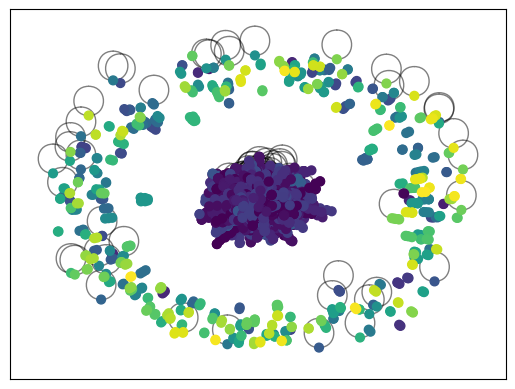

In [68]:
# 可视化，并用不同颜色标注不同的社群
pos = nx.spring_layout(net_undirected)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(net_undirected, pos, partition.keys(), node_size=40,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(net_undirected, pos, alpha=0.5)
plt.show()


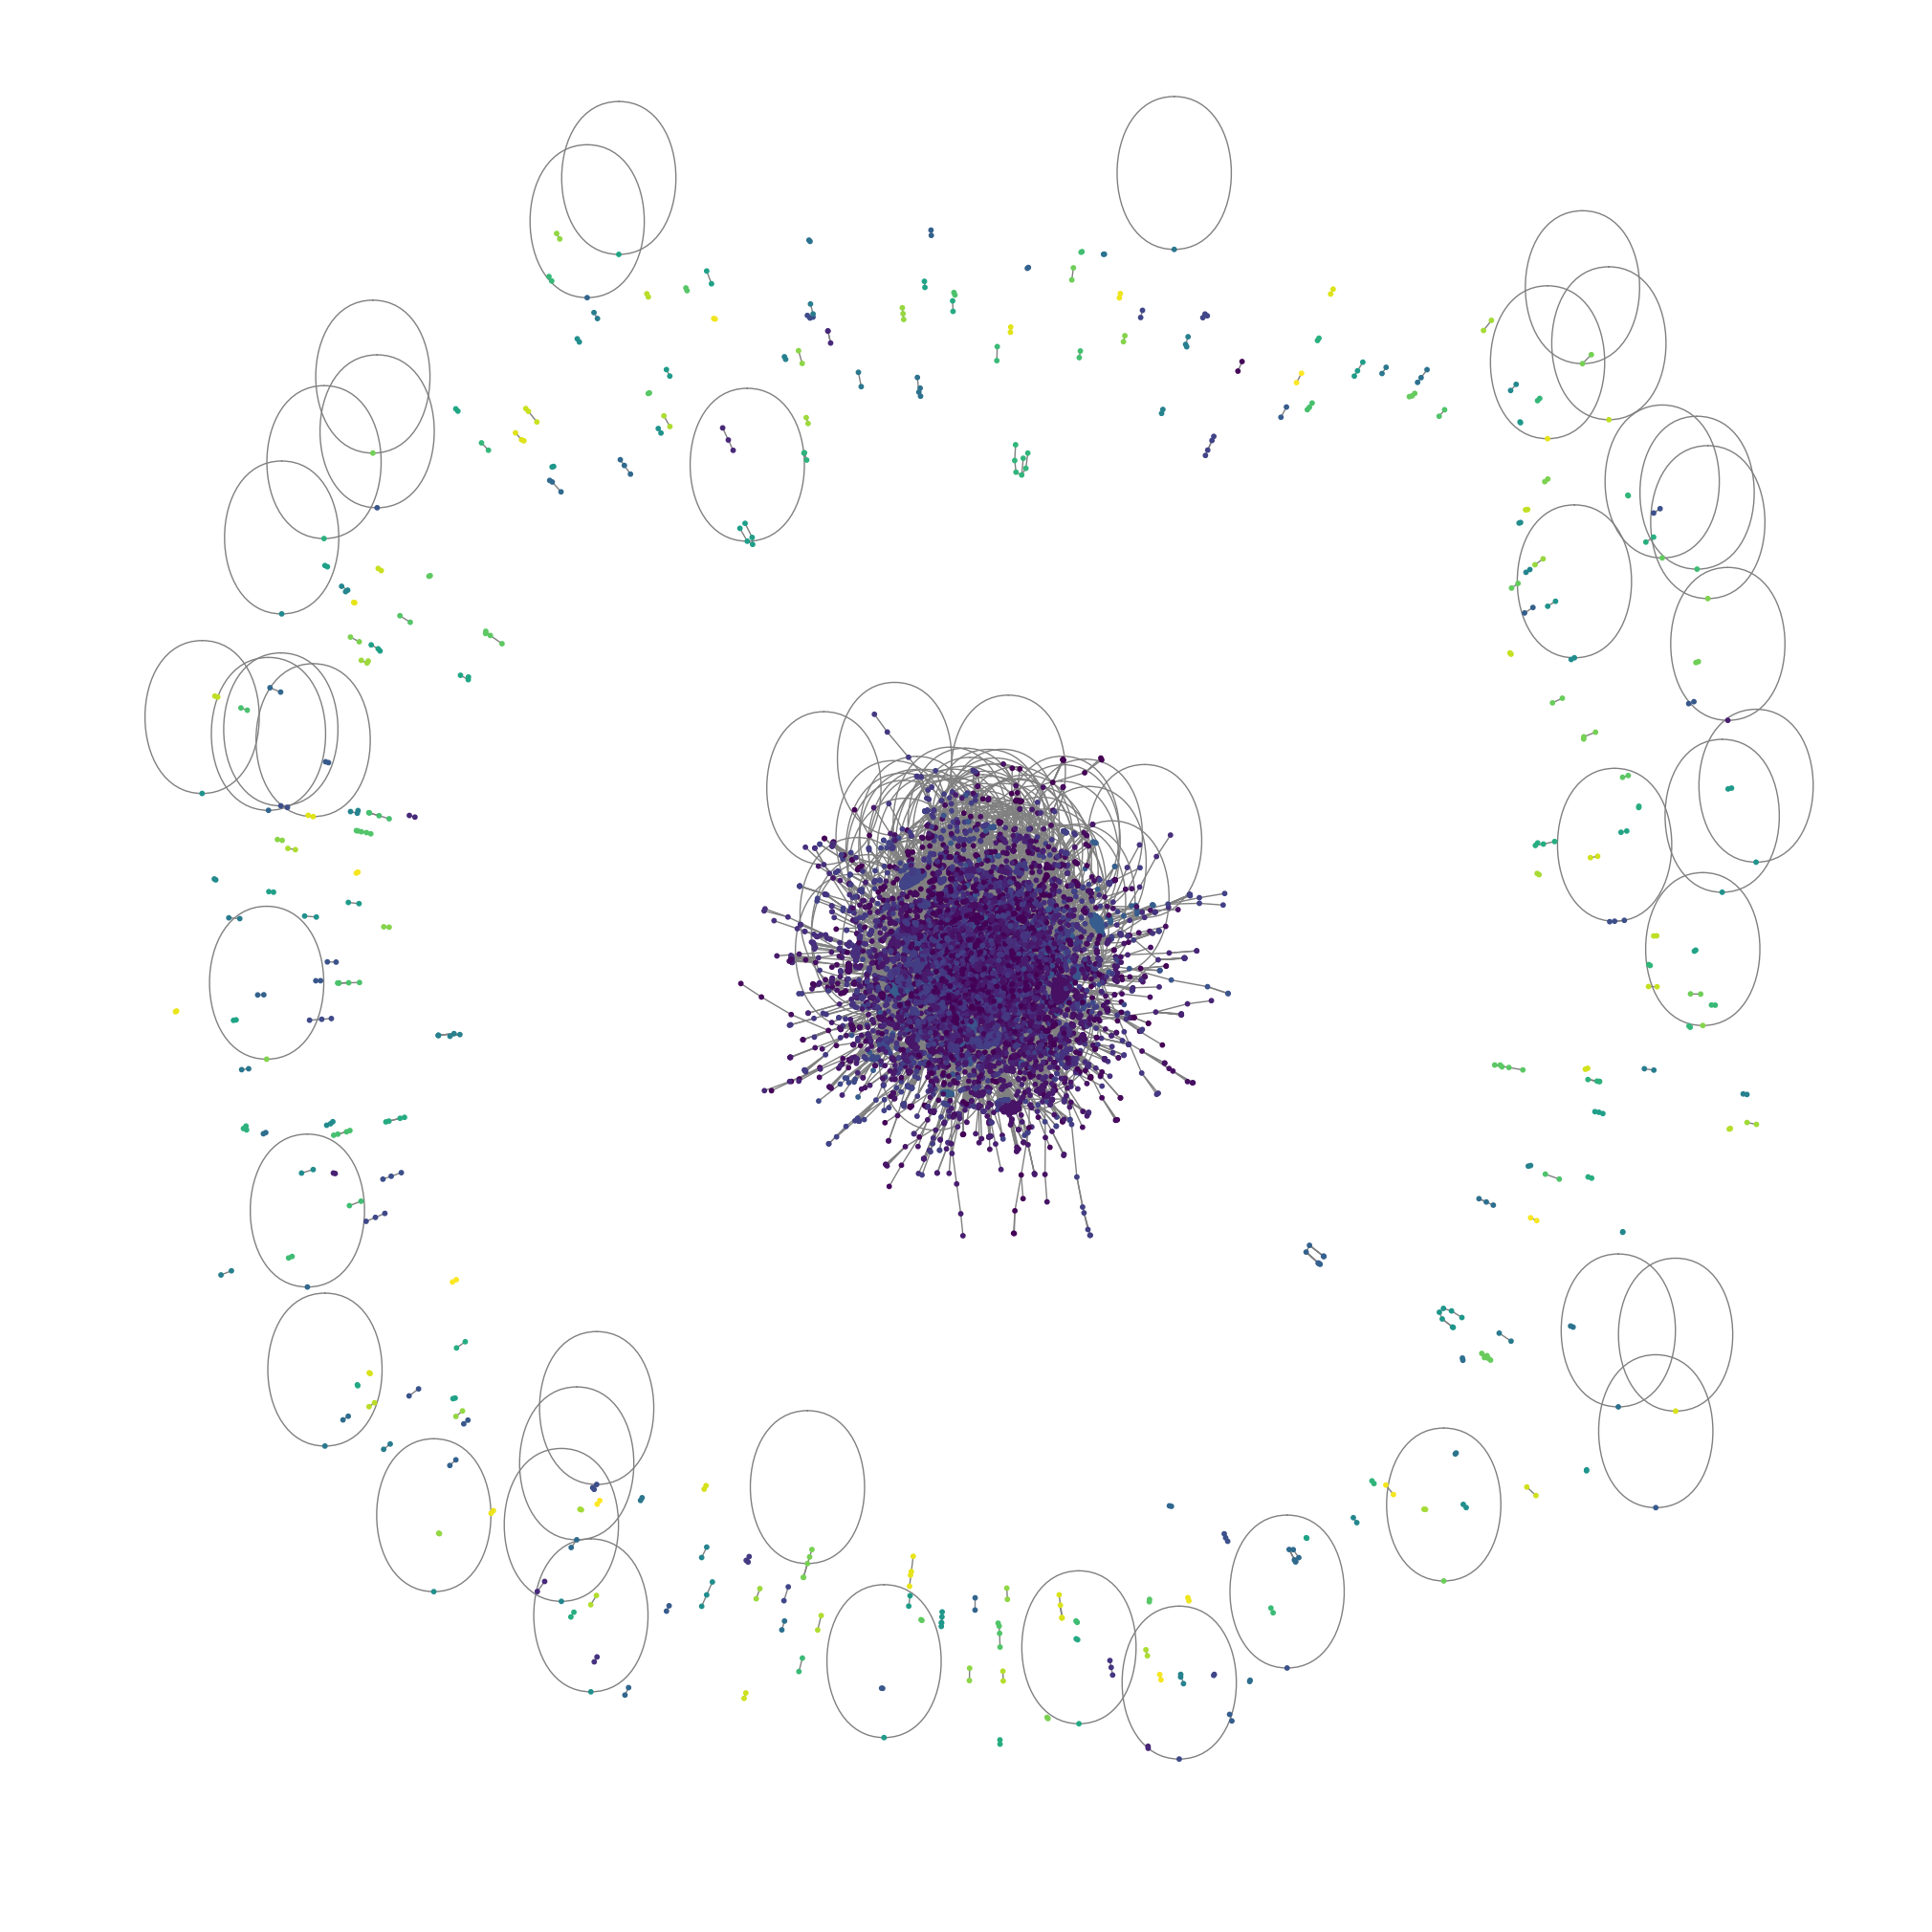

In [67]:
# 运用之前网络挖掘课的方法
pos = nx.spring_layout(net_undirected)
values = [partition.get(node) for node in net_undirected.nodes()] #生成一个list，每个值表示给某个note染什么颜色
# print(values)

cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize=(20, 20))
nx.draw(net_undirected, cmap=cmap, node_color=values, with_labels=False, edge_color='gray', # camp只是为了画图颜色好看
        node_size=10, pos=nx.spring_layout(net_undirected))

In [8]:
# 计算网络的聚集系数
clustering_coefficient = nx.average_clustering(net)
# 输出结果
print("网络的聚集系数为：", clustering_coefficient)

网络的聚集系数为： 0.00932727993338755
